In [21]:
import os
import glob
import pickle
import torchaudio
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Use a known seaborn style that exists:
plt.style.use("seaborn-v0_8-darkgrid")


In [22]:
def get_all_audio_files(folder):
    """Recursively traverse folder to return all .wav and .pkf file paths."""
    audio_files = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.wav', '.pkf')):
                full_path = os.path.join(root, file)
                audio_files.append(full_path)
    return audio_files

def count_files_by_extension(files_list):
    """Return dictionary with counts for each extension."""
    counts = {'.wav': 0, '.pkf': 0}
    for f in files_list:
        ext = os.path.splitext(f)[1].lower()
        if ext in counts:
            counts[ext] += 1
    return counts

def load_audio(filepath, sr=192000):
    """Load audio from .wav or .pkf file and resample from 48000 Hz to target sr."""
    ext = os.path.splitext(filepath)[1].lower()
    if ext == ".wav":
        try:
            waveform, _ = torchaudio.load(filepath)
            waveform = waveform.numpy()[0]  # Assume single-channel
        except Exception as e:
            print(f"Error loading WAV file {filepath}: {e}")
            return None
    elif ext == ".pkf":
        try:
            with open(filepath, "rb") as f:
                waveform = pickle.load(f)
            waveform = np.array(waveform, dtype=np.float32)
        except Exception as e:
            print(f"Pickle loading failed for {filepath}: {e}")
            try:
                with open(filepath, "rb") as f:
                    _ = f.read(20)  # Skip header bytes
                    raw_data = f.read()
                waveform = np.frombuffer(raw_data, dtype=np.float32)
            except Exception as e2:
                print(f"Fallback loading failed for {filepath}: {e2}")
                return None
    else:
        print(f"Unsupported file type: {filepath}")
        return None
    try:
        waveform = librosa.resample(waveform, orig_sr=48000, target_sr=sr)
    except Exception as e:
        print(f"Error during resampling {filepath}: {e}")
        return None
    return waveform

def waveform_to_logmel(waveform, sr=192000, n_mels=128, n_fft=2048, hop_length=512):
    try:
        S = librosa.feature.melspectrogram(y=waveform, sr=sr, n_fft=n_fft,
                                           hop_length=hop_length, n_mels=n_mels)
        log_S = librosa.power_to_db(S, ref=np.max)
    except Exception as e:
        print(f"Error generating spectrogram: {e}")
        return None
    return log_S

def compute_spectral_centroid(waveform, sr=192000):
    centroid = librosa.feature.spectral_centroid(y=waveform, sr=sr)
    return np.mean(centroid)

def compute_spectral_rolloff(waveform, sr=192000):
    rolloff = librosa.feature.spectral_rolloff(y=waveform, sr=sr)
    return np.mean(rolloff)


In [23]:
parent_folder = "Cleaned Bat Echolocation calls of South India"

all_files = get_all_audio_files(parent_folder)
total_files = len(all_files)
ext_counts = count_files_by_extension(all_files)

print(f"Total audio files in '{parent_folder}': {total_files}")
print("File counts by extension:", ext_counts)


Total audio files in 'Cleaned Bat Echolocation calls of South India': 5808
File counts by extension: {'.wav': 3067, '.pkf': 2741}


In [24]:
species_counts = {}
species_ext_counts = {}

# List immediate subfolders as species folders
species_folders = [os.path.join(parent_folder, d) for d in os.listdir(parent_folder)
                   if os.path.isdir(os.path.join(parent_folder, d))]

for species_path in species_folders:
    species_name = os.path.basename(species_path)
    files = get_all_audio_files(species_path)
    species_counts[species_name] = len(files)
    species_ext_counts[species_name] = count_files_by_extension(files)
    print(f"Species: {species_name}")
    print(f"  Total files: {len(files)}")
    print(f"  Extension counts: {species_ext_counts[species_name]}")

species_df = pd.DataFrame({
    "Species": list(species_counts.keys()),
    "Total Files": list(species_counts.values())
}).sort_values(by="Total Files", ascending=False)


Species: Chaerephon plicatus
  Total files: 12
  Extension counts: {'.wav': 12, '.pkf': 0}
Species: Hesperotenus tickelli
  Total files: 5
  Extension counts: {'.wav': 5, '.pkf': 0}
Species: Hipposideros ater
  Total files: 67
  Extension counts: {'.wav': 67, '.pkf': 0}
Species: Hipposideros fulvus
  Total files: 50
  Extension counts: {'.wav': 25, '.pkf': 25}
Species: Hipposideros hyphophyllus
  Total files: 33
  Extension counts: {'.wav': 33, '.pkf': 0}
Species: Hipposideros lankadiva
  Total files: 222
  Extension counts: {'.wav': 111, '.pkf': 111}
Species: Hipposideros pamona
  Total files: 207
  Extension counts: {'.wav': 115, '.pkf': 92}
Species: Hipposideros speoris
  Total files: 1166
  Extension counts: {'.wav': 647, '.pkf': 519}
Species: Lyroderma lyra (Megaderma lyra)
  Total files: 180
  Extension counts: {'.wav': 91, '.pkf': 89}
Species: Megaderma spasma
  Total files: 28
  Extension counts: {'.wav': 15, '.pkf': 13}
Species: Miniopterus philipsi
  Total files: 34
  Extensi

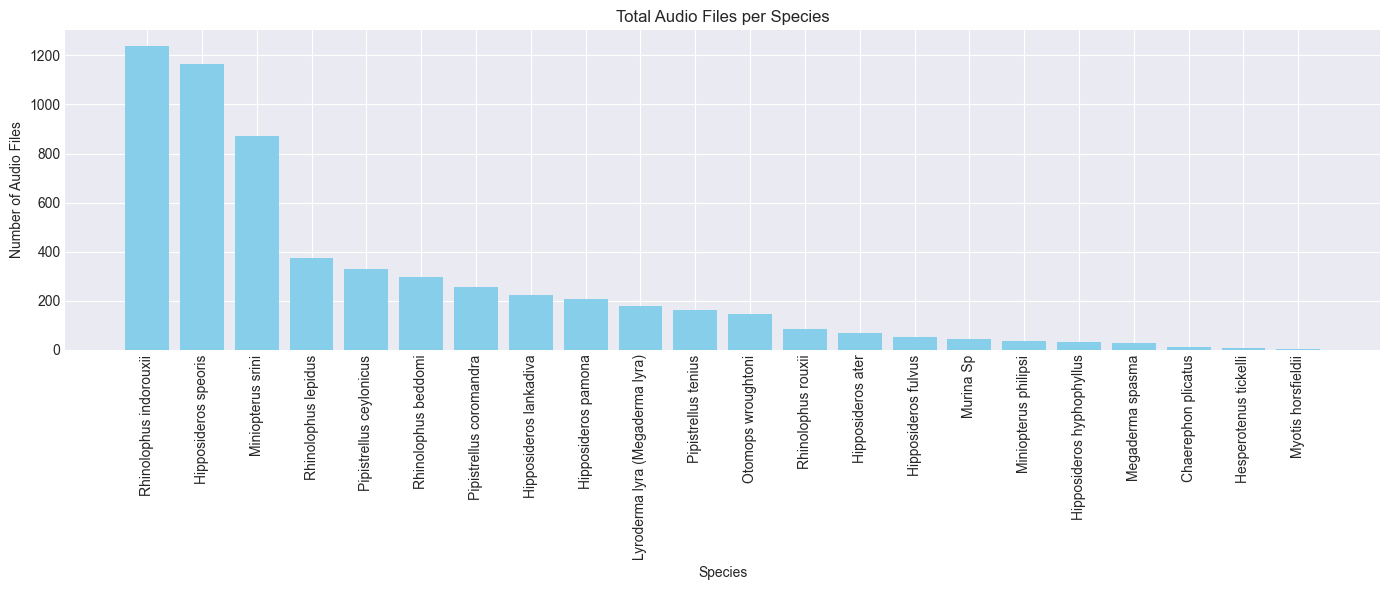

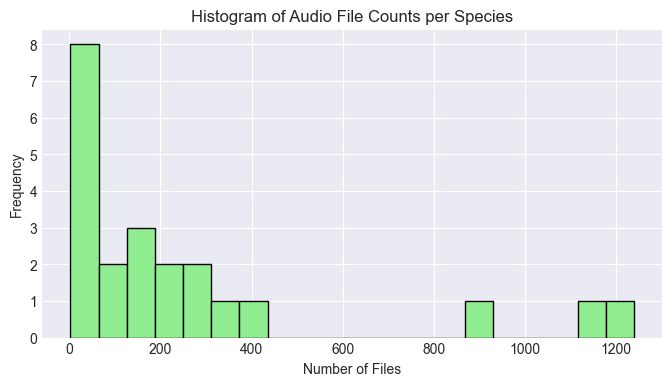

In [25]:
plt.figure(figsize=(14,6))
plt.bar(species_df["Species"], species_df["Total Files"], color='skyblue')
plt.xlabel("Species")
plt.ylabel("Number of Audio Files")
plt.title("Total Audio Files per Species")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.hist(species_df["Total Files"], bins=20, color='lightgreen', edgecolor='black')
plt.xlabel("Number of Files")
plt.ylabel("Frequency")
plt.title("Histogram of Audio File Counts per Species")
plt.show()


In [26]:
sorted_species = sorted(species_counts.items(), key=lambda x: x[1], reverse=True)
top5 = sorted_species[:5]
least5 = sorted_species[-5:]

print("Top 5 most recorded species:")
for sp, cnt in top5:
    print(f"  {sp}: {cnt} files")

print("\nLeast 5 recorded species:")
for sp, cnt in least5:
    print(f"  {sp}: {cnt} files")


Top 5 most recorded species:
  Rhinolophus indorouxii: 1240 files
  Hipposideros speoris: 1166 files
  Miniopterus srini: 870 files
  Rhinolophus lepidus: 374 files
  Pipistrellus ceylonicus: 331 files

Least 5 recorded species:
  Hipposideros hyphophyllus: 33 files
  Megaderma spasma: 28 files
  Chaerephon plicatus: 12 files
  Hesperotenus tickelli: 5 files
  Myotis horsfieldii: 2 files



Spectral Feature Analysis for two random species:


c:\Users\jambu\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Species: Hipposideros hyphophyllus
  Sample file: Cleaned Bat Echolocation calls of South India\Hipposideros hyphophyllus\20240816_194703_2_20240816194703.wav
  Mean Spectral Centroid: 12166.10 Hz
  Mean Spectral Rolloff: 14077.59 Hz


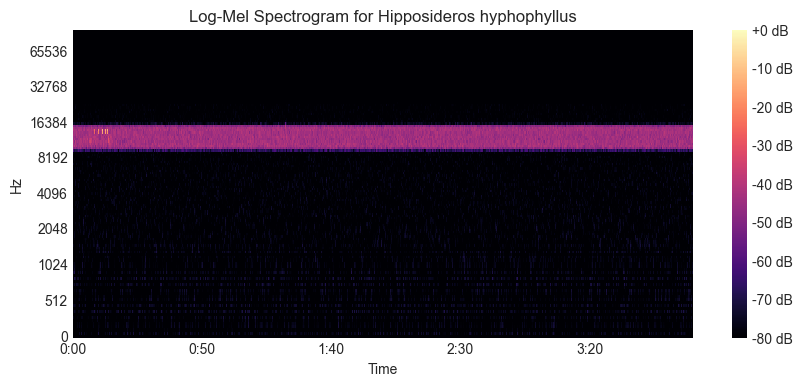

Species: Miniopterus srini
  Sample file: Cleaned Bat Echolocation calls of South India\Miniopterus srini\Dandeli Dec 2022- Mali Cave\20221220_191500_2_20221220191507.wav
  Mean Spectral Centroid: 8562.04 Hz
  Mean Spectral Rolloff: 10671.38 Hz


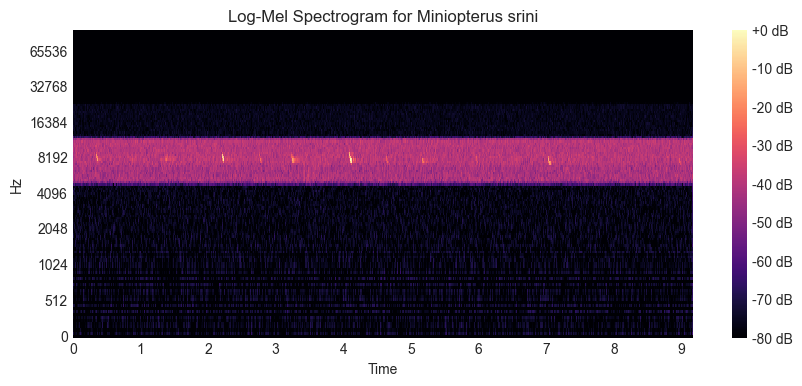

In [27]:
random_species = random.sample(list(species_counts.keys()), 2)
print("\nSpectral Feature Analysis for two random species:")
for sp in random_species:
    species_path = os.path.join(parent_folder, sp)
    files = get_all_audio_files(species_path)
    if files:
        sample_file = random.choice(files)
        waveform = load_audio(sample_file)
        if waveform is None:
            continue
        spec = waveform_to_logmel(waveform)
        centroid = compute_spectral_centroid(waveform)
        rolloff = compute_spectral_rolloff(waveform)
        print(f"Species: {sp}")
        print(f"  Sample file: {sample_file}")
        print(f"  Mean Spectral Centroid: {centroid:.2f} Hz")
        print(f"  Mean Spectral Rolloff: {rolloff:.2f} Hz")
        plt.figure(figsize=(10,4))
        librosa.display.specshow(spec, sr=192000, hop_length=512, x_axis='time', y_axis='mel')
        plt.title(f"Log-Mel Spectrogram for {sp}")
        plt.colorbar(format='%+2.0f dB')
        plt.show()
    else:
        print(f"No files found for species: {sp}")



For the most recorded species (Rhinolophus indorouxii):
  Sample file: Cleaned Bat Echolocation calls of South India\Rhinolophus indorouxii\Bhagavathi-Kudremukha SM4-Bat calls\BCITSMU02693_20240211_212201_20240211212201.wav
  Log-Mel Spectrogram min value: -80.00, max value: 0.00


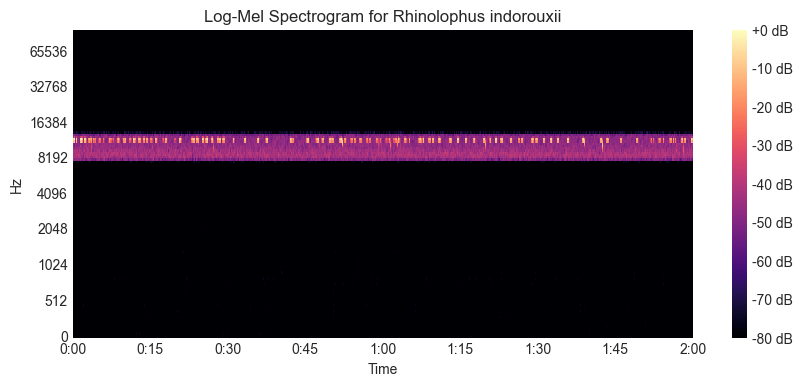


For the least recorded species (Hipposideros hyphophyllus):
  Sample file: Cleaned Bat Echolocation calls of South India\Hipposideros hyphophyllus\20240816_195126_4_20240816195126.wav
  Log-Mel Spectrogram min value: -80.00, max value: 0.00


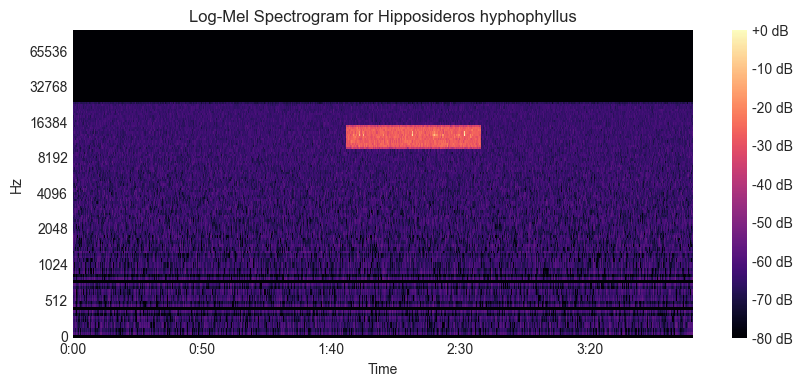

In [28]:
if top5:
    most_recorded_species = top5[0][0]
    most_files = get_all_audio_files(os.path.join(parent_folder, most_recorded_species))
    sample_most = random.choice(most_files)
    waveform_most = load_audio(sample_most)
    spec_most = waveform_to_logmel(waveform_most)
    print(f"\nFor the most recorded species ({most_recorded_species}):")
    print(f"  Sample file: {sample_most}")
    print(f"  Log-Mel Spectrogram min value: {np.min(spec_most):.2f}, max value: {np.max(spec_most):.2f}")
    plt.figure(figsize=(10,4))
    librosa.display.specshow(spec_most, sr=192000, hop_length=512, x_axis='time', y_axis='mel')
    plt.title(f"Log-Mel Spectrogram for {most_recorded_species}")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

if least5:
    least_recorded_species = least5[0][0]
    least_files = get_all_audio_files(os.path.join(parent_folder, least_recorded_species))
    sample_least = random.choice(least_files)
    waveform_least = load_audio(sample_least)
    spec_least = waveform_to_logmel(waveform_least)
    print(f"\nFor the least recorded species ({least_recorded_species}):")
    print(f"  Sample file: {sample_least}")
    print(f"  Log-Mel Spectrogram min value: {np.min(spec_least):.2f}, max value: {np.max(spec_least):.2f}")
    plt.figure(figsize=(10,4))
    librosa.display.specshow(spec_least, sr=192000, hop_length=512, x_axis='time', y_axis='mel')
    plt.title(f"Log-Mel Spectrogram for {least_recorded_species}")
    plt.colorbar(format='%+2.0f dB')
    plt.show()


In [29]:
summary_lines = []
summary_lines.append(f"Parent Folder: {parent_folder}")
summary_lines.append(f"Total Audio Files: {total_files}")
summary_lines.append(f"File Counts by Extension: {ext_counts}\n")
summary_lines.append("Per-Species File Counts:")
for sp in species_df["Species"]:
    wav_count = species_ext_counts[sp].get(".wav", 0)
    pkf_count = species_ext_counts[sp].get(".pkf", 0)
    summary_lines.append(f"  {sp}: {species_counts[sp]} files (WAV: {wav_count}, PKF: {pkf_count})")
summary_text = "\n".join(summary_lines)

print("\nSummary of Dataset:")
print(summary_text)



Summary of Dataset:
Parent Folder: Cleaned Bat Echolocation calls of South India
Total Audio Files: 5808
File Counts by Extension: {'.wav': 3067, '.pkf': 2741}

Per-Species File Counts:
  Rhinolophus indorouxii: 1240 files (WAV: 627, PKF: 613)
  Hipposideros speoris: 1166 files (WAV: 647, PKF: 519)
  Miniopterus srini: 870 files (WAV: 439, PKF: 431)
  Rhinolophus lepidus: 374 files (WAV: 193, PKF: 181)
  Pipistrellus ceylonicus: 331 files (WAV: 168, PKF: 163)
  Rhinolophus beddomi: 296 files (WAV: 148, PKF: 148)
  Pipistrellus coromandra: 255 files (WAV: 133, PKF: 122)
  Hipposideros lankadiva: 222 files (WAV: 111, PKF: 111)
  Hipposideros pamona: 207 files (WAV: 115, PKF: 92)
  Lyroderma lyra (Megaderma lyra): 180 files (WAV: 91, PKF: 89)
  Pipistrellus tenius: 161 files (WAV: 82, PKF: 79)
  Otomops wroughtoni: 144 files (WAV: 72, PKF: 72)
  Rhinolophus rouxii: 86 files (WAV: 38, PKF: 48)
  Hipposideros ater: 67 files (WAV: 67, PKF: 0)
  Hipposideros fulvus: 50 files (WAV: 25, PKF: 2

Using WAV file: Cleaned Bat Echolocation calls of South India\Pipistrellus ceylonicus\Avani-Ganji Gunte- Oct 2021\20211015_125509_20211015125509.wav


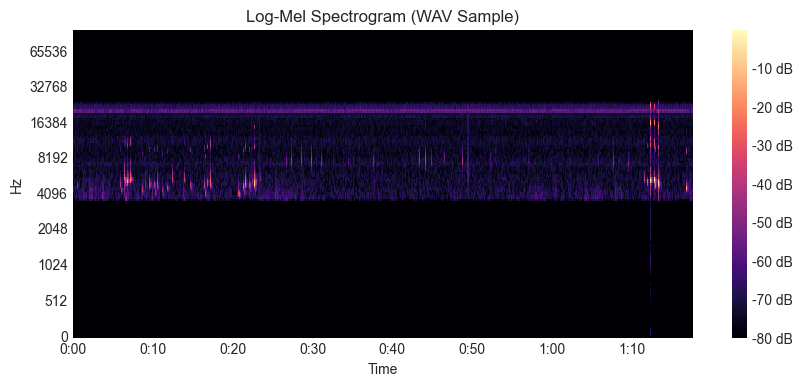

In [49]:
import os, glob, pickle, torchaudio, numpy as np, librosa, librosa.display, matplotlib.pyplot as plt

def load_audio(filepath, sr=192000):
    ext = os.path.splitext(filepath)[1].lower()
    if ext not in [".wav", ".pkf"]:
        print(f"Unsupported file type for {filepath}")
        return None
    if ext == ".wav":
        try:
            waveform, _ = torchaudio.load(filepath)
            # Ensure single channel by selecting the first channel
            waveform = waveform[0].numpy()
        except Exception as e:
            print(f"Error loading WAV file {filepath}: {e}")
            return None
    elif ext == ".pkf":
        try:
            with open(filepath, "rb") as f:
                waveform = pickle.load(f)
            waveform = np.array(waveform, dtype=np.float32)
        except Exception as e:
            print(f"Pickle loading failed for {filepath}: {e}")
            try:
                with open(filepath, "rb") as f:
                    _ = f.read(20)  # Skip header
                    raw_data = f.read()
                waveform = np.frombuffer(raw_data, dtype=np.float32)
            except Exception as e2:
                print(f"Fallback loading failed for {filepath}: {e2}")
                return None
    try:
        waveform = librosa.resample(waveform, orig_sr=48000, target_sr=sr)
    except Exception as e:
        print(f"Error during resampling {filepath}: {e}")
        return None
    return waveform

def waveform_to_logmel(waveform, sr=192000, n_mels=128, n_fft=2048, hop_length=512):
    try:
        S = librosa.feature.melspectrogram(y=waveform, sr=sr, n_fft=n_fft,
                                           hop_length=hop_length, n_mels=n_mels)
        log_S = librosa.power_to_db(S, ref=np.max)
    except Exception as e:
        print(f"Error generating spectrogram: {e}")
        return None
    return log_S

# Test on a sample WAV file from one species folder.
wav_files = glob.glob(os.path.join("Cleaned Bat Echolocation calls of South India", "Pipistrellus ceylonicus", "**/*.wav"), recursive=True)
if wav_files:
    sample_wav = wav_files[0]
    print("Using WAV file:", sample_wav)
    waveform = load_audio(sample_wav)
    if waveform is not None and waveform.size > 0:
        spec = waveform_to_logmel(waveform)
        if spec is not None:
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(spec, sr=192000, hop_length=512, x_axis='time', y_axis='mel')
            plt.title("Log-Mel Spectrogram (WAV Sample)")
            plt.colorbar(format='%+2.0f dB')
            plt.show()
    else:
        print("Failed to load WAV sample.")
else:
    print("No WAV files found.")


Using PKF file: Cleaned Bat Echolocation calls of South India\Pipistrellus ceylonicus\Avani-Ganji Gunte- Oct 2021\20211015_125509_20211015125509.pkf
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Pipistrellus ceylonicus\Avani-Ganji Gunte- Oct 2021\20211015_125509_20211015125509.pkf: invalid load key, 'k'.


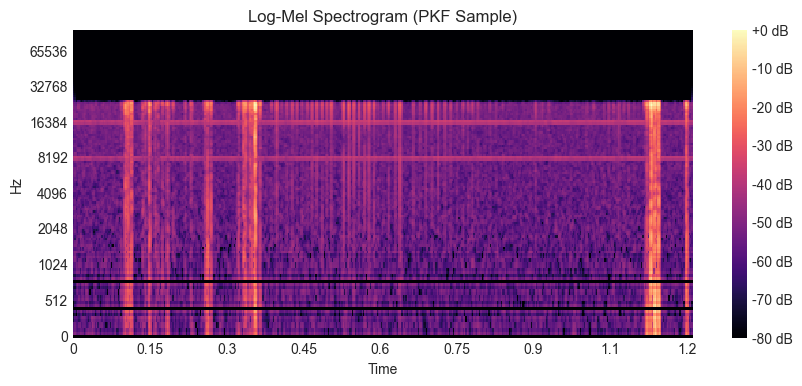

In [50]:
# Test on a sample PKF file from one species folder.
pkf_files = glob.glob(os.path.join("Cleaned Bat Echolocation calls of South India", "Pipistrellus ceylonicus", "**/*.pkf"), recursive=True)
if pkf_files:
    sample_pkf = pkf_files[0]
    print("Using PKF file:", sample_pkf)
    waveform = load_audio(sample_pkf)
    if waveform is not None and waveform.size > 0:
        spec = waveform_to_logmel(waveform)
        if spec is not None:
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(spec, sr=192000, hop_length=512, x_axis='time', y_axis='mel')
            plt.title("Log-Mel Spectrogram (PKF Sample)")
            plt.colorbar(format='%+2.0f dB')
            plt.show()
    else:
        print("Skipping PKF file due to loading error.")
else:
    print("No PKF files found.")


Plotting waveform for: Cleaned Bat Echolocation calls of South India\Miniopterus srini\Castle Rock Ivoli-Apr-2023\20230420_192131_20230420192131.wav


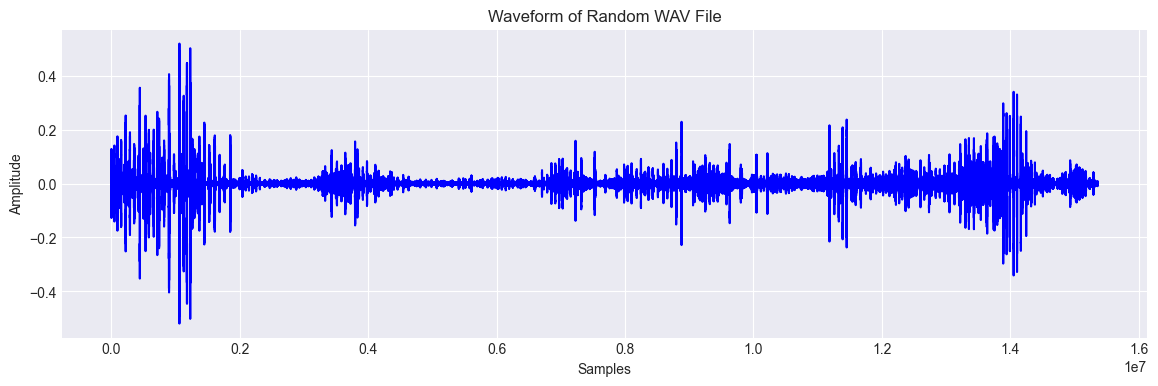

In [51]:
import random
all_wav_files = glob.glob(os.path.join("Cleaned Bat Echolocation calls of South India", "**/*.wav"), recursive=True)
if all_wav_files:
    sample_file = random.choice(all_wav_files)
    print("Plotting waveform for:", sample_file)
    waveform = load_audio(sample_file)
    if waveform is not None:
        plt.figure(figsize=(14, 4))
        plt.plot(waveform, color='blue')
        plt.title("Waveform of Random WAV File")
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.show()
    else:
        print("Failed to load waveform.")
else:
    print("No WAV files found.")


Plotting waveform for: Cleaned Bat Echolocation calls of South India\Miniopterus srini\Castle Rock Ivoli-Apr-2023\20230420_195437_1_20230420195437.pkf
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Miniopterus srini\Castle Rock Ivoli-Apr-2023\20230420_195437_1_20230420195437.pkf: invalid load key, 'k'.


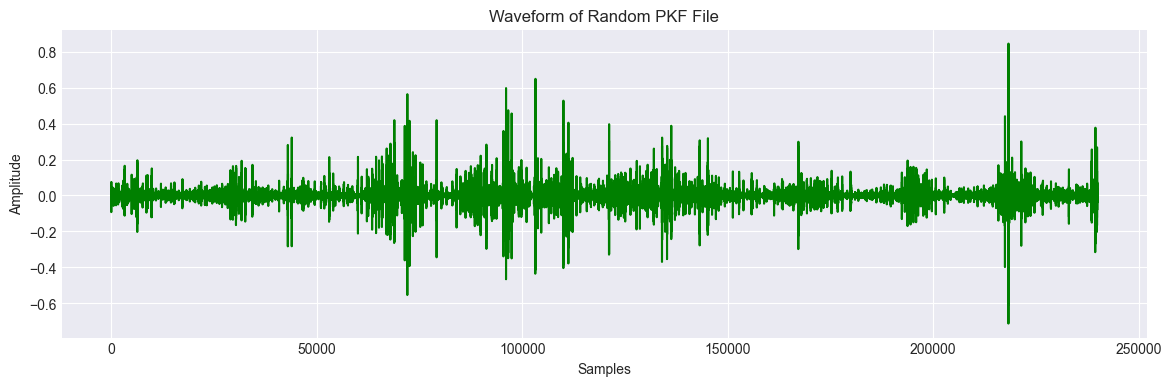

In [52]:
all_pkf_files = glob.glob(os.path.join("Cleaned Bat Echolocation calls of South India", "**/*.pkf"), recursive=True)
if all_pkf_files:
    sample_file = random.choice(all_pkf_files)
    print("Plotting waveform for:", sample_file)
    waveform = load_audio(sample_file)
    if waveform is not None:
        plt.figure(figsize=(14, 4))
        plt.plot(waveform, color='green')
        plt.title("Waveform of Random PKF File")
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.show()
    else:
        print("Failed to load waveform.")
else:
    print("No PKF files found.")


Pickle loading failed for Cleaned Bat Echolocation calls of South India\Hipposideros fulvus\Anekal 01 Nov 2020\20201101_114716_2_20201101114716.pkf: invalid load key, 'k'.
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Hipposideros fulvus\Anekal 01 Nov 2020\20201101_114828_2_20201101114828.pkf: invalid load key, 'k'.
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Hipposideros fulvus\Belgaum Dec 2019\BCIT_N_20110101_175454_20110101175454.pkf: invalid load key, 'k'.
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Hipposideros fulvus\Belgaum Dec 2019\BCIT_N_20191227_204554_20191227204554.pkf: invalid load key, 'k'.
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Hipposideros fulvus\Belgaum-Dec 2019\20191225_104048_20191225104048.pkf: invalid load key, 'k'.
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Hipposideros fulvus\Castle Rock Ivoli-Apr-2023\20230420_191523_3_2

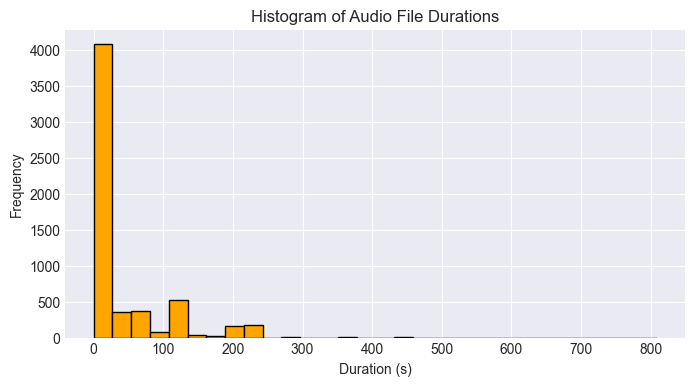

In [55]:
durations = []
for f in get_all_audio_files("Cleaned Bat Echolocation calls of South India"):
    waveform = load_audio(f)
    if waveform is not None:
        durations.append(len(waveform) / 192000)  # duration in seconds

if durations:
    plt.figure(figsize=(8, 4))
    plt.hist(durations, bins=30, color='orange', edgecolor='black')
    plt.xlabel("Duration (s)")
    plt.ylabel("Frequency")
    plt.title("Histogram of Audio File Durations")
    plt.show()
else:
    print("No duration data available.")


Pickle loading failed for Cleaned Bat Echolocation calls of South India\Hipposideros fulvus\Anekal 01 Nov 2020\20201101_114716_2_20201101114716.pkf: invalid load key, 'k'.
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Hipposideros fulvus\Anekal 01 Nov 2020\20201101_114828_2_20201101114828.pkf: invalid load key, 'k'.
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Hipposideros fulvus\Belgaum Dec 2019\BCIT_N_20110101_175454_20110101175454.pkf: invalid load key, 'k'.
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Hipposideros fulvus\Belgaum Dec 2019\BCIT_N_20191227_204554_20191227204554.pkf: invalid load key, 'k'.
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Hipposideros fulvus\Belgaum-Dec 2019\20191225_104048_20191225104048.pkf: invalid load key, 'k'.
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Hipposideros fulvus\Castle Rock Ivoli-Apr-2023\20230420_191523_3_2

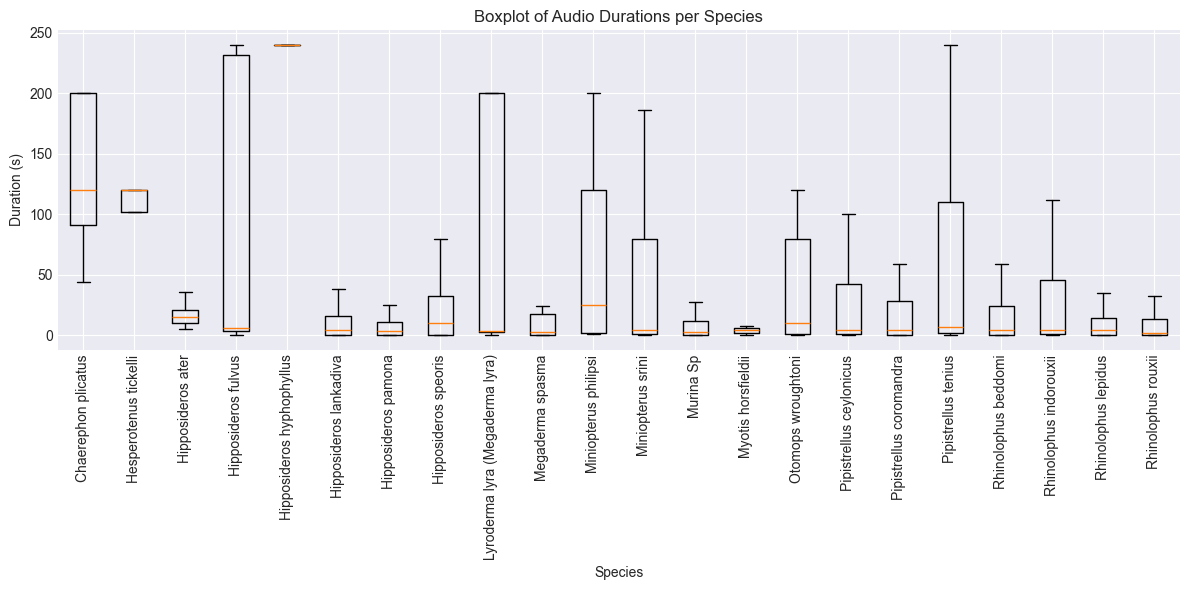

In [57]:
species_durations = {}
for species_folder in [os.path.join("Cleaned Bat Echolocation calls of South India", d) 
                       for d in os.listdir("Cleaned Bat Echolocation calls of South India") if os.path.isdir(os.path.join("Cleaned Bat Echolocation calls of South India", d))]:
    sp_name = os.path.basename(species_folder)
    files = get_all_audio_files(species_folder)
    durations = []
    for f in files:
        waveform = load_audio(f)
        if waveform is not None:
            durations.append(len(waveform) / 192000)
    if durations:
        species_durations[sp_name] = durations

if species_durations:
    plt.figure(figsize=(12, 6))
    data = [species_durations[sp] for sp in species_durations]
    plt.boxplot(data, labels=list(species_durations.keys()), showfliers=False)
    plt.xlabel("Species")
    plt.ylabel("Duration (s)")
    plt.title("Boxplot of Audio Durations per Species")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("No duration data available.")


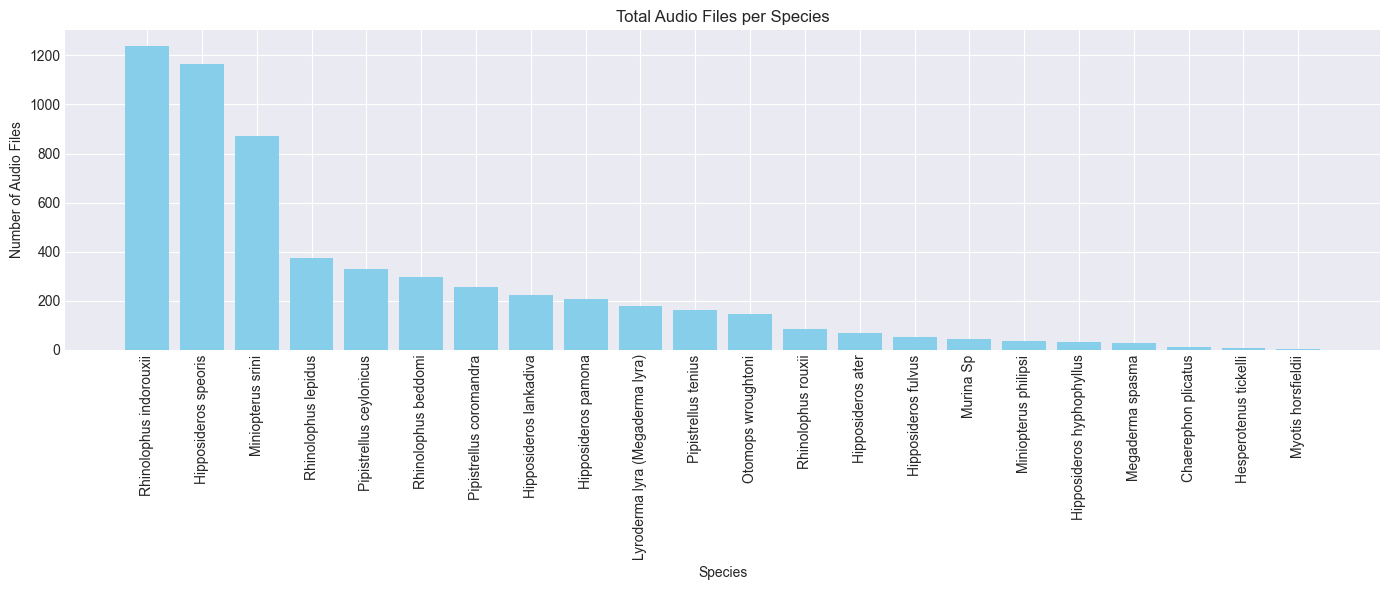

In [58]:
species_counts = {}
species_folders = [os.path.join("Cleaned Bat Echolocation calls of South India", d) 
                   for d in os.listdir("Cleaned Bat Echolocation calls of South India") if os.path.isdir(os.path.join("Cleaned Bat Echolocation calls of South India", d))]
for folder in species_folders:
    sp_name = os.path.basename(folder)
    files = get_all_audio_files(folder)
    species_counts[sp_name] = len(files)

species_df = pd.DataFrame({"Species": list(species_counts.keys()),
                           "Total Files": list(species_counts.values())}).sort_values(by="Total Files", ascending=False)

plt.figure(figsize=(14,6))
plt.bar(species_df["Species"], species_df["Total Files"], color='skyblue')
plt.xlabel("Species")
plt.ylabel("Number of Audio Files")
plt.title("Total Audio Files per Species")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


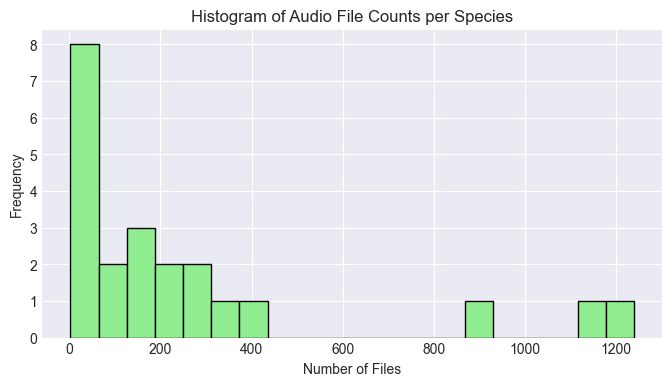

In [59]:
plt.figure(figsize=(8,4))
plt.hist(species_df["Total Files"], bins=20, color='lightgreen', edgecolor='black')
plt.xlabel("Number of Files")
plt.ylabel("Frequency")
plt.title("Histogram of Audio File Counts per Species")
plt.show()


In [65]:
import os
import glob
import pandas as pd

def get_all_audio_files(folder):
    """Recursively traverse folder to collect all .wav and .pkf file paths."""
    audio_files = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.wav', '.pkf')):
                audio_files.append(os.path.join(root, file))
    return audio_files

def count_files_by_extension(files_list):
    """Return dictionary with counts for each extension."""
    counts = {'.wav': 0, '.pkf': 0}
    for f in files_list:
        ext = os.path.splitext(f)[1].lower()
        if ext in counts:
            counts[ext] += 1
    return counts

# Parent folder (contains 29 species folders; each species may have subfolders)
parent_folder = "Cleaned Bat Echolocation calls of South India"

# Get all audio files in parent folder
all_files = get_all_audio_files(parent_folder)
total_files = len(all_files)
ext_counts = count_files_by_extension(all_files)

# Compute per-species counts (immediate subfolders)
species_counts = {}
species_ext_counts = {}
species_folders = [os.path.join(parent_folder, d) for d in os.listdir(parent_folder)
                   if os.path.isdir(os.path.join(parent_folder, d))]

for species_folder in species_folders:
    species_name = os.path.basename(species_folder)
    files = get_all_audio_files(species_folder)
    species_counts[species_name] = len(files)
    species_ext_counts[species_name] = count_files_by_extension(files)

# Create a DataFrame for species counts
species_df = pd.DataFrame({
    "Species": list(species_counts.keys()),
    "Total Files": list(species_counts.values())
}).sort_values(by="Total Files", ascending=False)

# Identify Top 5 and Least 5 recorded species
sorted_species = sorted(species_counts.items(), key=lambda x: x[1], reverse=True)
top5 = sorted_species[:5]
least5 = sorted_species[-5:]

# Create a summary text output
summary_lines = []
summary_lines.append(f"Parent Folder: {parent_folder}")
summary_lines.append(f"Total Audio Files: {total_files}")
summary_lines.append(f"File Counts by Extension: {ext_counts}\n")
summary_lines.append("Per-Species File Counts:")
for sp in species_df["Species"]:
    wav_count = species_ext_counts[sp].get(".wav", 0)
    pkf_count = species_ext_counts[sp].get(".pkf", 0)
    summary_lines.append(f"  {sp}: {species_counts[sp]} files (WAV: {wav_count}, PKF: {pkf_count})")
summary_lines.append("\nTop 5 Most Recorded Species:")
for sp, cnt in top5:
    summary_lines.append(f"  {sp}: {cnt} files")
summary_lines.append("\nLeast 5 Recorded Species:")
for sp, cnt in least5:
    summary_lines.append(f"  {sp}: {cnt} files")
summary_text = "\n".join(summary_lines)

print("Summary of Dataset:")
print(summary_text)


Summary of Dataset:
Parent Folder: Cleaned Bat Echolocation calls of South India
Total Audio Files: 5808
File Counts by Extension: {'.wav': 3067, '.pkf': 2741}

Per-Species File Counts:
  Rhinolophus indorouxii: 1240 files (WAV: 627, PKF: 613)
  Hipposideros speoris: 1166 files (WAV: 647, PKF: 519)
  Miniopterus srini: 870 files (WAV: 439, PKF: 431)
  Rhinolophus lepidus: 374 files (WAV: 193, PKF: 181)
  Pipistrellus ceylonicus: 331 files (WAV: 168, PKF: 163)
  Rhinolophus beddomi: 296 files (WAV: 148, PKF: 148)
  Pipistrellus coromandra: 255 files (WAV: 133, PKF: 122)
  Hipposideros lankadiva: 222 files (WAV: 111, PKF: 111)
  Hipposideros pamona: 207 files (WAV: 115, PKF: 92)
  Lyroderma lyra (Megaderma lyra): 180 files (WAV: 91, PKF: 89)
  Pipistrellus tenius: 161 files (WAV: 82, PKF: 79)
  Otomops wroughtoni: 144 files (WAV: 72, PKF: 72)
  Rhinolophus rouxii: 86 files (WAV: 38, PKF: 48)
  Hipposideros ater: 67 files (WAV: 67, PKF: 0)
  Hipposideros fulvus: 50 files (WAV: 25, PKF: 25

Total audio files found in parent folder: 5808
Processing 100 randomly selected audio files...
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Hipposideros speoris\Devarayasamudra Mar 2024\20240309_184459_2_20240309184514.pkf: invalid load key, 'k'.
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Lyroderma lyra (Megaderma lyra)\Avani & Ganji gunte-15-October-2021\NOISE_20211015_141632_20211015141632.pkf: invalid load key, 'k'.
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Hipposideros speoris\Dandeli-Bhimgad\BCIT___20110102_225742_20110102225742.pkf: invalid load key, 'k'.
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Miniopterus srini\Castle Rock Ivoli-Apr-2023-EPTH\20230420_194627_1_20230420194644.pkf: invalid load key, 'k'.
Pickle loading failed for Cleaned Bat Echolocation calls of South India\Rhinolophus indorouxii\Belgaum Dec 2019\BCIT___20110102_175458_20110102175458.pkf: invalid 

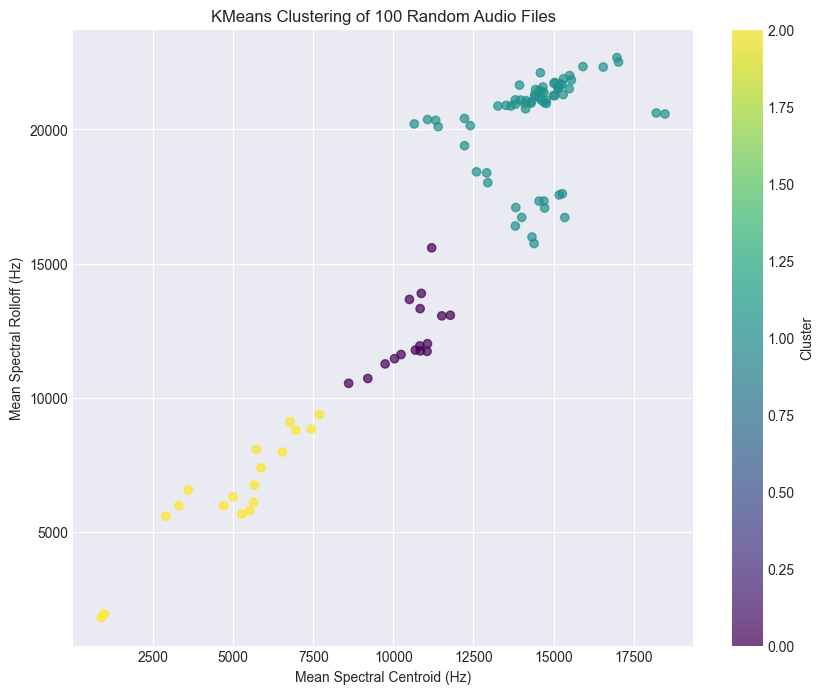

Clustered Sample (first 10 entries):
       Centroid       Rolloff  Cluster  \
0   8603.741400  10541.608635        0   
1  13263.339583  20874.156605        1   
2  12219.838344  20409.801136        1   
3  13808.210442  20938.636364        1   
4  16552.505543  22325.816761        1   
5  15167.641602  21568.965517        1   
6  14298.089012  20981.831395        1   
7  18209.747723  20614.239913        1   
8  12914.343823  18383.438459        1   
9   6950.557755   8800.823951        2   

                                                File  
0  Cleaned Bat Echolocation calls of South India\...  
1  Cleaned Bat Echolocation calls of South India\...  
2  Cleaned Bat Echolocation calls of South India\...  
3  Cleaned Bat Echolocation calls of South India\...  
4  Cleaned Bat Echolocation calls of South India\...  
5  Cleaned Bat Echolocation calls of South India\...  
6  Cleaned Bat Echolocation calls of South India\...  
7  Cleaned Bat Echolocation calls of South India\...  
8  Cl

In [67]:
import os
import glob
import pickle
import torchaudio
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns

# Helper Functions
def get_all_audio_files(folder):
    """Recursively traverse folder to collect all .wav and .pkf file paths."""
    audio_files = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.wav', '.pkf')):
                audio_files.append(os.path.join(root, file))
    return audio_files

def load_audio(filepath, sr=192000):
    """Load audio from .wav or .pkf file (with fallback for PKF) and resample from 48000 Hz."""
    ext = os.path.splitext(filepath)[1].lower()
    if ext not in [".wav", ".pkf"]:
        print(f"Unsupported file type: {filepath}")
        return None
    if ext == ".wav":
        try:
            waveform, _ = torchaudio.load(filepath)
            waveform = waveform.numpy()[0]  # Assume single-channel
        except Exception as e:
            print(f"Error loading WAV file {filepath}: {e}")
            return None
    elif ext == ".pkf":
        try:
            with open(filepath, "rb") as f:
                waveform = pickle.load(f)
            waveform = np.array(waveform, dtype=np.float32)
        except Exception as e:
            print(f"Pickle loading failed for {filepath}: {e}")
            try:
                with open(filepath, "rb") as f:
                    _ = f.read(20)  # Skip header bytes
                    raw_data = f.read()
                waveform = np.frombuffer(raw_data, dtype=np.float32)
            except Exception as e2:
                print(f"Fallback loading failed for {filepath}: {e2}")
                return None
    try:
        waveform = librosa.resample(waveform, orig_sr=48000, target_sr=sr)
    except Exception as e:
        print(f"Error resampling {filepath}: {e}")
        return None
    return waveform

def compute_spectral_centroid(waveform, sr=192000):
    centroid = librosa.feature.spectral_centroid(y=waveform, sr=sr)
    return np.mean(centroid)

def compute_spectral_rolloff(waveform, sr=192000):
    rolloff = librosa.feature.spectral_rolloff(y=waveform, sr=sr)
    return np.mean(rolloff)

# Set parent folder (should contain subfolders for each species)
parent_folder = "Cleaned Bat Echolocation calls of South India"

all_files = get_all_audio_files(parent_folder)
print(f"Total audio files found in parent folder: {len(all_files)}")

# Randomly sample 100 files (or fewer if not available)
sample_files = random.sample(all_files, min(100, len(all_files)))
print(f"Processing {len(sample_files)} randomly selected audio files...")

features = []
file_paths = []  # Save corresponding file paths
for f in sample_files:
    waveform = load_audio(f)
    if waveform is None or waveform.size == 0:
        continue
    centroid = compute_spectral_centroid(waveform)
    rolloff = compute_spectral_rolloff(waveform)
    features.append([centroid, rolloff])
    file_paths.append(f)
features = np.array(features)
print(f"Extracted features for {features.shape[0]} files.")

# Apply KMeans clustering (using k=3 clusters, as an example)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(features)

# Plot scatter of features with cluster assignments
plt.figure(figsize=(10,8))
scatter = plt.scatter(features[:,0], features[:,1], c=clusters, cmap='viridis', alpha=0.7)
plt.xlabel("Mean Spectral Centroid (Hz)")
plt.ylabel("Mean Spectral Rolloff (Hz)")
plt.title("KMeans Clustering of 100 Random Audio Files")
plt.colorbar(scatter, label="Cluster")
plt.show()

# Create a DataFrame to show sample clustering results
df_cluster = pd.DataFrame(features, columns=["Centroid", "Rolloff"])
df_cluster["Cluster"] = clusters
df_cluster["File"] = file_paths
print("Clustered Sample (first 10 entries):")
print(df_cluster.head(10))


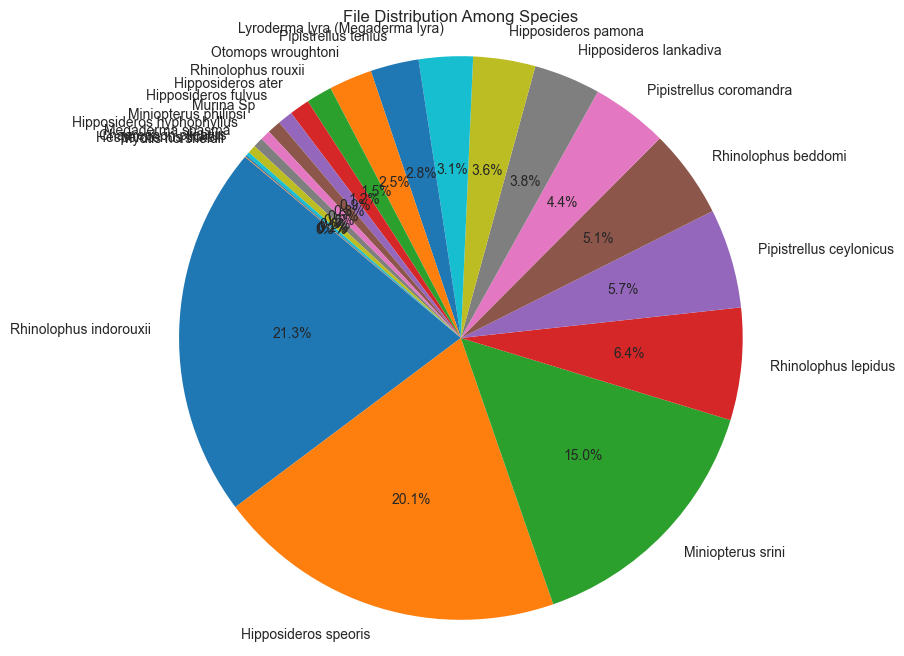

In [68]:
plt.figure(figsize=(8,8))
plt.pie(species_df["Total Files"], labels=species_df["Species"], autopct='%1.1f%%', startangle=140)
plt.title("File Distribution Among Species")
plt.axis("equal")
plt.show()


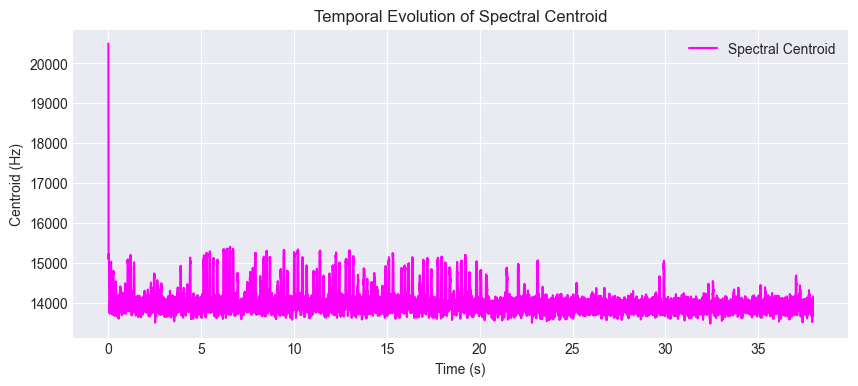

In [69]:
sample_file = random.choice(audio_files)
waveform = load_audio(sample_file)
if waveform is not None:
    centroid = librosa.feature.spectral_centroid(y=waveform, sr=192000)[0]
    times = librosa.frames_to_time(np.arange(len(centroid)), sr=192000, hop_length=512)
    plt.figure(figsize=(10,4))
    plt.plot(times, centroid, color="magenta", label="Spectral Centroid")
    plt.xlabel("Time (s)")
    plt.ylabel("Centroid (Hz)")
    plt.title("Temporal Evolution of Spectral Centroid")
    plt.legend()
    plt.show()
else:
    print("Failed to load sample for temporal centroid plot.")


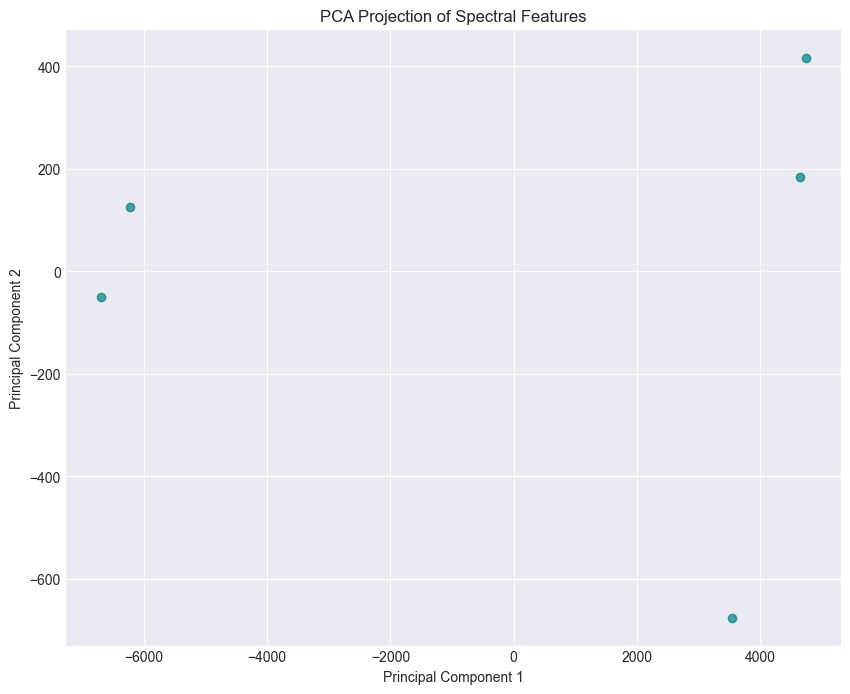

In [70]:
from sklearn.decomposition import PCA
if feature_list:
    features_arr = np.array(feature_list)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features_arr)
    plt.figure(figsize=(10,8))
    plt.scatter(pca_result[:,0], pca_result[:,1], c='teal', alpha=0.7)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA Projection of Spectral Features")
    plt.show()
else:
    print("No features available for PCA.")
